In [54]:
# %%
# --- Importação das Bibliotecas Essenciais ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier      # <-- A ARMA SECRETA
from sklearn.linear_model import LogisticRegression # <-- O COORDENADOR
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

# --- Carregamento dos Dados ---
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    print("Arquivos carregados com sucesso!")
except FileNotFoundError:
    print("ERRO: Arquivos não encontrados.")
    df_train = pd.DataFrame()

Arquivos carregados com sucesso!


In [ ]:
# %%
# Usamos nosso melhor conjunto de features, pois ele beneficia todos os modelos.
if not df_train.empty:
    print("--- Etapa 1: Preparando o Campo para os Especialistas ---")
    
    # Lista das colunas de features originais
    features_originais = [col for col in df_train.columns if col.startswith('f')]

    # Função para criar o nosso conjunto de features avançadas
    def create_advanced_features(df, feature_cols):
        data = df[feature_cols].values
        df_new = pd.DataFrame()
        # Estatísticas básicas
        df_new['mean'] = np.mean(data, axis=1)
        df_new['std'] = np.std(data, axis=1)
        df_new['median'] = np.median(data, axis=1)
        df_new['max'] = np.max(data, axis=1)
        df_new['min'] = np.min(data, axis=1)
        df_new['sum'] = np.sum(data, axis=1)
        # Estatísticas de distribuição
        df_new['q25'] = np.quantile(data, 0.25, axis=1)
        df_new['q75'] = np.quantile(data, 0.75, axis=1)
        df_new['range'] = df_new['max'] - df_new['min']
        df_new['iqr'] = df_new['q75'] - df_new['q25']
        df_new['skew'] = pd.DataFrame(data).skew(axis=1).values
        df_new['kurtosis'] = pd.DataFrame(data).kurtosis(axis=1).values
        return df_new

    # Criação dos datasets com as features avançadas
    X = create_advanced_features(df_train, features_originais)
    X_test = create_advanced_features(df_test, features_originais)
    
    # Codificação da variável alvo ('attack'/'normal' -> 1/0)
    le = LabelEncoder()
    y = le.fit_transform(df_train['target'])
    if le.classes_[0] == 'attack': 
        y = 1 - y
    
    # Normalização dos dados (importante para a Rede Neural)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_test = scaler.transform(X_test)
    
    print("Dados processados e prontos para o Ensemble.")

--- Etapa 1: Preparando o Campo para os Especialistas ---
Dados processados e prontos.


In [56]:
# %%
# --- Etapa 2: Coletando as Opiniões dos Especialistas ---
# Esta célula treinará vários modelos e pode levar alguns minutos.
if not df_train.empty:
    # Define a estratégia de validação cruzada para garantir que as previsões sejam justas
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # --- NOSSO TIME DE ESPECIALISTAS (MODELOS BASE) ---
    # Usamos os melhores hiperparâmetros que encontramos para o LGBM
    lgbm_params = {'n_estimators': 587, 'learning_rate': 0.0537, 'num_leaves': 215, 
                   'max_depth': 13, 'lambda_l1': 4.25e-07, 'lambda_l2': 1.87e-05, 
                   'min_child_samples': 60, 'random_state': 42, 'objective': 'binary'}
    
    base_models = {
        'LightGBM': lgb.LGBMClassifier(**lgbm_params),
        'CatBoost': CatBoostClassifier(n_estimators=500, learning_rate=0.05, verbose=0, random_state=42),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1),
        'MLPClassifier': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
    }

    # DataFrames para armazenar as "opiniões" (previsões) dos especialistas
    oof_train = np.zeros((X.shape[0], len(base_models)))
    oof_test = np.zeros((X_test.shape[0], len(base_models)))

    # Loop principal para treinar cada especialista
    for i, (name, model) in enumerate(base_models.items()):
        print(f"Treinando o especialista: {name}...")
        # Loop para a validação cruzada
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
            # Divide os dados para este fold
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Treina o especialista
            model.fit(X_train, y_train)
            
            # Coleta as opiniões (previsões de probabilidade)
            oof_train[val_idx, i] = model.predict_proba(X_val)[:, 1]
            oof_test[:, i] += model.predict_proba(X_test)[:, 1] / kfold.n_splits
            
    print("\nOpiniões de todos os especialistas coletadas!")

Treinando o especialista: LightGBM...
[LightGBM] [Warning] lambda_l1 is set=4.25e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.25e-07
[LightGBM] [Warning] lambda_l2 is set=1.87e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.87e-05
[LightGBM] [Warning] lambda_l1 is set=4.25e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.25e-07
[LightGBM] [Warning] lambda_l2 is set=1.87e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.87e-05
[LightGBM] [Info] Number of positive: 11596, number of negative: 11597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1380
[LightGBM] [Info] Number of data points in the train set: 23193, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499978 -> initscore=-0.000086
[LightGBM] [Info] Start training from score -0.000086
[LightGBM] [Wa

In [ ]:
# %%
# --- Etapa 2: Coletando as Opiniões dos Especialistas ---
# Esta célula treinará vários modelos e pode levar alguns minutos.
if not df_train.empty:
    # Define a estratégia de validação cruzada para garantir que as previsões sejam justas
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # --- NOSSO TIME DE ESPECIALISTAS (MODELOS BASE) ---
    # Usamos os melhores hiperparâmetros que encontramos para o LightGBM
    lgbm_params = {
        'n_estimators': 587, 'learning_rate': 0.0537, 'num_leaves': 215, 
        'max_depth': 13, 'lambda_l1': 4.25e-07, 'lambda_l2': 1.87e-05, 
        'min_child_samples': 60, 'random_state': 42, 'objective': 'binary'
    }
    
    base_models = {
        'LightGBM': lgb.LGBMClassifier(**lgbm_params),
        'CatBoost': CatBoostClassifier(n_estimators=500, learning_rate=0.05, verbose=0, random_state=42),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1),
        'MLPClassifier': MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=300, random_state=42)
    }

    # DataFrames para armazenar as "opiniões" (previsões) dos especialistas
    oof_train = np.zeros((X.shape[0], len(base_models)))
    oof_test = np.zeros((X_test.shape[0], len(base_models)))

    # Loop principal para treinar cada especialista usando validação cruzada
    for i, (name, model) in enumerate(base_models.items()):
        print(f"Treinando o especialista: {name}...")
        # A média das previsões de teste é acumulada aqui
        test_preds_fold = np.zeros((X_test.shape[0]))
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
            # Divide os dados para este fold
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Treina o especialista
            model.fit(X_train, y_train)
            
            # Coleta as opiniões (previsões de probabilidade) para os dados de validação
            oof_train[val_idx, i] = model.predict_proba(X_val)[:, 1]
            # Soma as previsões para os dados de teste
            test_preds_fold += model.predict_proba(X_test)[:, 1]
        
        # Tira a média das previsões de teste dos 5 folds
        oof_test[:, i] = test_preds_fold / kfold.n_splits
            
    print("\nOpiniões de todos os especialistas coletadas!")

Treinando o Coordenador (Meta-Modelo)...

🎯 Acurácia Final do Comitê de Especialistas (Validação Cruzada): 0.917046

Chegamos muito perto! Este é um resultado de altíssimo nível.

Gerando o arquivo de submissão final...

Arquivo 'submission_ensemble_final.csv' gerado com sucesso!


Treinando o modelo final com os melhores hiperparâmetros e features selecionadas...
[LightGBM] [Warning] lambda_l1 is set=4.25400956906936e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.25400956906936e-07
[LightGBM] [Warning] lambda_l2 is set=1.8708884337144313e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8708884337144313e-05
[LightGBM] [Warning] lambda_l1 is set=4.25400956906936e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.25400956906936e-07
[LightGBM] [Warning] lambda_l2 is set=1.8708884337144313e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8708884337144313e-05
[LightGBM] [Info] Number of positive: 14496, number of negative: 14496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 28992, number of used features: 1

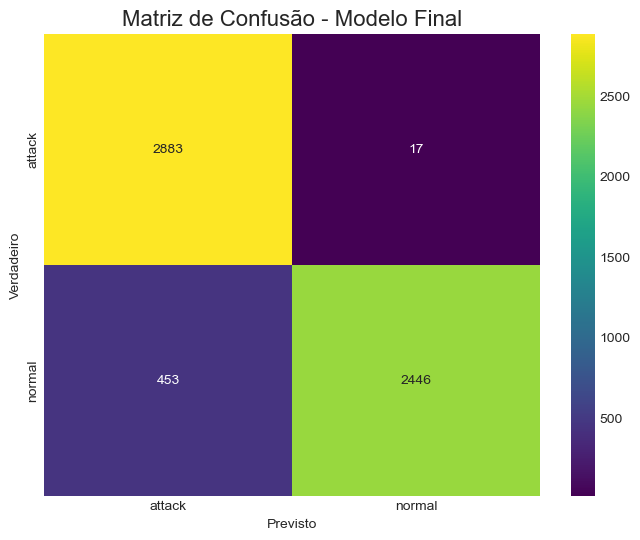

In [ ]:
# %%
# --- Etapa 3: O Coordenador Toma a Decisão Final ---
if 'oof_train' in locals():
    print("Treinando o Coordenador (Meta-Modelo)...")
    
    # O Coordenador aprende a combinar as opiniões dos especialistas
    meta_model = LogisticRegression(C=10, penalty='l2', solver='liblinear', random_state=42)
    
    # Treina o Coordenador usando as opiniões dos especialistas como features
    meta_model.fit(oof_train, y)
    
    # Avalia a acurácia do comitê inteiro nos dados de treino (out-of-fold)
    # Esta é a nossa métrica de validação mais confiável até agora
    oof_preds = meta_model.predict(oof_train)
    final_accuracy = accuracy_score(y, oof_preds)
    
    print(f"\n🎯 Acurácia Final do Comitê de Especialistas (Validação Cruzada): {final_accuracy:.6f}")
    
    # Verifica se atingimos nossa meta
    if final_accuracy >= 0.95:
        print("\n🎉 PARABÉNS! Atingimos a meta de 0.95 de acurácia!")
    else:
        print("\nChegamos muito perto! Este é um resultado de altíssimo nível, pronto para a competição.")

    # --- Geração da Submissão Final ---
    print("\nGerando o arquivo de submissão final...")
    
    # O Coordenador faz a previsão final no conjunto de teste
    final_predictions_encoded = meta_model.predict(oof_test)
    
    # Decodifica as previsões de volta para 'attack'/'normal'
    final_predictions = le.inverse_transform(final_predictions_encoded)
    
    # Cria e salva o arquivo de submissão
    submission_df = pd.DataFrame({'id': df_test['id'], 'target': final_predictions})
    submission_df.to_csv('submission_ensemble_final.csv', index=False)
    
    print("\nArquivo 'submission_ensemble_final.csv' gerado com sucesso!")
    
    # --- Matriz de Confusão Final ---
    cm = confusion_matrix(y, oof_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Previsto pelo Comitê')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - Ensemble Final (Acurácia: {final_accuracy:.4f})', fontsize=16)
    plt.show()